In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

print(os.listdir("/kaggle/input/"))
print(os.listdir("/kaggle/input/skin-cancer-mnist-ham10000/"))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

['skin-cancer-mnist-ham10000']
['hmnist_8_8_RGB.csv', 'hmnist_28_28_RGB.csv', 'HAM10000_images_part_1', 'ham10000_images_part_1', 'hmnist_8_8_L.csv', 'HAM10000_images_part_2', 'ham10000_images_part_2', 'hmnist_28_28_L.csv', 'HAM10000_metadata.csv']


In [2]:
#read metadata
df_skin = pd.read_csv('/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv')

df_skin.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [3]:
# lesion names are given in the description of the challenge
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

lesion_ID_dict = {
    'nv': 0,
    'mel': 1,
    'bkl': 2,
    'bcc': 3,
    'akiec': 4,
    'vasc': 5,
    'df': 6
}

lesion_names = ['Melanocytic nevi','Melanoma','Benign keratosis-like lesions ',
               'Basal cell carcinoma','Actinic keratoses','Vascular lesions',
               'Dermatofibroma']

lesion_names_short = ['nv','mel','bkl','bcc','akiec','vasc','df']

df_skin['lesion_type']=df_skin['dx'].map(lesion_type_dict)
df_skin['lesion_ID'] = df_skin['dx'].map(lesion_ID_dict)

print('Total number of images',len(df_skin))
print('The problem is unbalanced, since Melanocytic nevi is much more frequent that other labels')

df_skin['lesion_type'].value_counts()

Total number of images 10015
The problem is unbalanced, since Melanocytic nevi is much more frequent that other labels


Melanocytic nevi                  6705
Melanoma                          1113
Benign keratosis-like lesions     1099
Basal cell carcinoma               514
Actinic keratoses                  327
Vascular lesions                   142
Dermatofibroma                     115
Name: lesion_type, dtype: int64

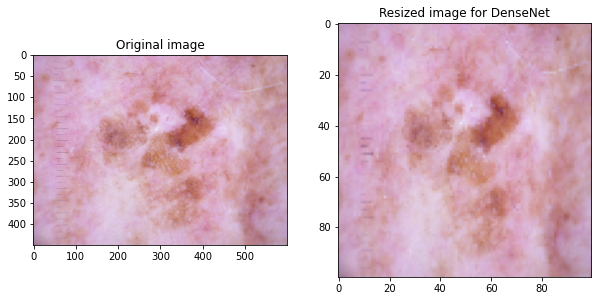

In [4]:
# read the first image
fname_images = np.array(df_skin['image_id'])
file_to_read ='/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/'+str(fname_images[0])+'.jpg'

import cv2
from cv2 import imread, resize

img = imread(file_to_read)
img2 = resize(img,(100,100))

# show one exampe image

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(img[:,:,::-1])
plt.title('Original image')
plt.subplot(1,2,2)
plt.imshow(img2[:,:,::-1])
plt.title('Resized image for DenseNet')
plt.show()

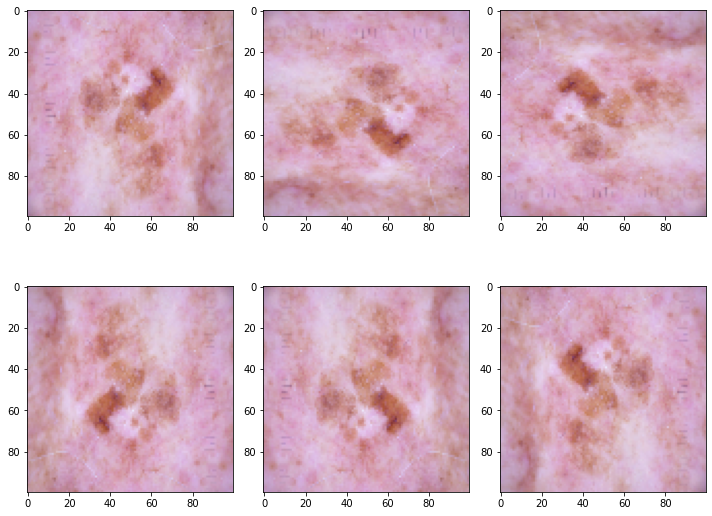

In [5]:
def produce_new_img(img2):
    # produce new images by rotating of flipping the original one
    # this helps to increase the dimension of the dataset, avoiding overfitting of a single class
    imga = cv2.rotate(img2,cv2.ROTATE_90_CLOCKWISE)
    imgb = cv2.rotate(img2,cv2.ROTATE_90_COUNTERCLOCKWISE)
    imgc = cv2.rotate(img2,cv2.ROTATE_180)
    imgd = cv2.flip(img2,0)
    imge = cv2.flip(img2,1)
    return imga,imgb,imgc,imgd,imge

new_img = produce_new_img(img2)

plt.figure(figsize=(10,8))
plt.subplot(2,3,1)
plt.imshow(img2[:,:,::-1])
for i in range(5):
    plt.subplot(2,3,2+i)
    plt.imshow(new_img[i][:,:,::-1])
plt.tight_layout()
plt.show()

In [6]:
# import images from 2 different folders

X = []
y = []

lista1 = os.listdir('/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/')
lista2 = os.listdir('/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_2/')


#import images from folder 1
for i in range(len(lista1)):
    fname_image = lista1[i]
    fname_ID = fname_image.replace('.jpg','')
    
    #features 
    file_to_read ='/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/'+str(fname_image)
    img = imread(file_to_read)
    img2 = resize(img,(100,100))
    X.append(img2)
    
    #targets
    output = np.array(df_skin[df_skin['image_id'] == fname_ID].lesion_ID)
    y.append(output[0])
    
    # add more images for class between 1-6, rotating them 
    if output != 0:
        new_img = produce_new_img(img2)
        for i in range(5):
            X.append(new_img[i])
            y.append(output[0])
       
    if i % int(100) == 0:
        print(i,'images loaded')

# import images from folder 2
for i in range(len(lista2)):
    fname_image = lista2[i]
    fname_ID = fname_image.replace('.jpg','')
    
    #features
    file_to_read ='/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_2/'+str(fname_image)
    img = imread(file_to_read)
    img2 = resize(img,(100,100))
    X.append(img2)
    
    #targets
    output = np.array(df_skin[df_skin['image_id'] == fname_ID].lesion_ID)
    y.append(output[0])
    
    # add more images for class between 1-6
    if output != 0:
        new_img = produce_new_img(img2)
        for i in range(5):
            X.append(new_img[i])
            y.append(output[0])
    
    if i % int(100) == 0:

        print(len(lista1)+i,'images loaded')

0 images loaded
100 images loaded
200 images loaded
300 images loaded
400 images loaded
500 images loaded
600 images loaded
700 images loaded
800 images loaded
1100 images loaded
1200 images loaded
1500 images loaded
1600 images loaded
1800 images loaded
2100 images loaded
2300 images loaded
2400 images loaded
2600 images loaded
2700 images loaded
2800 images loaded
2900 images loaded
3000 images loaded
3100 images loaded
3200 images loaded
3500 images loaded
3600 images loaded
3700 images loaded
3900 images loaded
4100 images loaded
4500 images loaded
4600 images loaded
4700 images loaded
4800 images loaded
4900 images loaded
5000 images loaded
5100 images loaded
5300 images loaded
5400 images loaded
5700 images loaded
5900 images loaded
6000 images loaded
6100 images loaded
6200 images loaded
6400 images loaded
6600 images loaded
6700 images loaded
6800 images loaded
6900 images loaded
7000 images loaded
7100 images loaded
7200 images loaded
7300 images loaded
7400 images loaded
7500

In [7]:
from keras.utils.np_utils import to_categorical

X = np.array(X)
y = np.array(y)

y_train = to_categorical(y, num_classes=7)

# #convert targets in dummy variables, as required by softmax activation function
# y_dumm = np.array(pd.get_dummies(y))

In [8]:
from sklearn.model_selection import train_test_split

# split in 80% training and 20% test data
X_train, X_test, y_train, y_test = train_test_split(X, y_train, test_size=0.33, random_state=50,stratify=y)


print('Train dataset shape',X_train.shape)
print('Test dataset shape',X_test.shape)

Train dataset shape (17798, 100, 100, 3)
Test dataset shape (8767, 100, 100, 3)


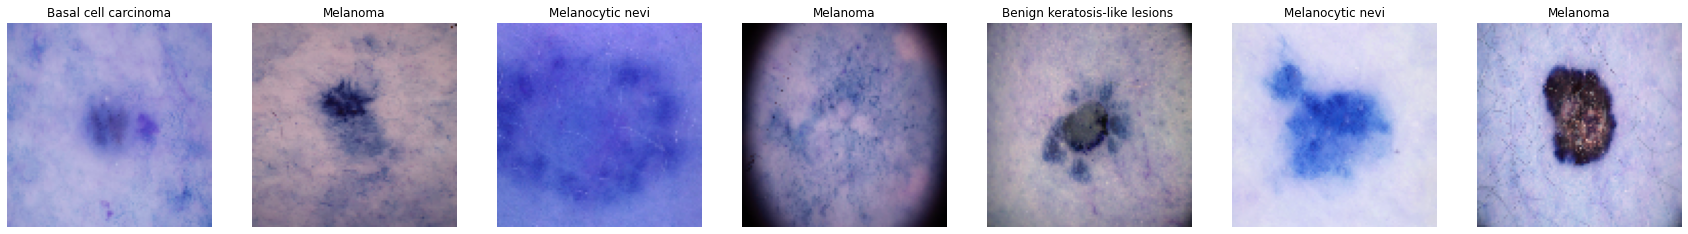

In [9]:
fig, ax = plt.subplots(1, 7, figsize=(30, 30))
for i in range(7):
    ax[i].set_axis_off()
    ax[i].imshow(X_train[i])
    ax[i].set_title(lesion_names[np.argmax(y_train[i])])

In [10]:
import keras
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.layers.core import Dropout, Activation
from keras.layers import Conv2D,BatchNormalization,MaxPool2D,Flatten,Dense

In [11]:
from sklearn.utils.class_weight import compute_class_weight
y_id = np.array(df_skin['lesion_ID'])

# compute weights for the loss function, because the problem is unbalanced
class_weights = np.around(compute_class_weight(class_weight='balanced',classes=np.unique(y_id),y=y),2)
class_weights = dict(zip(np.unique(y_id),class_weights))

print('The problem is unbalanced. We need to provide class_weights ')
print(class_weights)

The problem is unbalanced. We need to provide class_weights 
{0: 0.57, 1: 0.57, 2: 0.58, 3: 1.23, 4: 1.93, 5: 4.45, 6: 5.5}


In [12]:
import keras
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Dense, Input, Activation, Dropout, GlobalAveragePooling2D, \
    BatchNormalization, concatenate, AveragePooling2D
from keras.optimizers import Adam



def conv_layer(conv_x, filters):
    conv_x = BatchNormalization()(conv_x)
    conv_x = Activation('relu')(conv_x)
    conv_x = Conv2D(filters, (3, 3), kernel_initializer='he_uniform', padding='same', use_bias=False)(conv_x)
    conv_x = Dropout(0.2)(conv_x)

    return conv_x


def dense_block(block_x, filters, growth_rate, layers_in_block):
    for i in range(layers_in_block):
        each_layer = conv_layer(block_x, growth_rate)
        block_x = concatenate([block_x, each_layer], axis=-1)
        filters += growth_rate

    return block_x, filters


def transition_block(trans_x, tran_filters):
    trans_x = BatchNormalization()(trans_x)
    trans_x = Activation('relu')(trans_x)
    trans_x = Conv2D(tran_filters, (1, 1), kernel_initializer='he_uniform', padding='same', use_bias=False)(trans_x)
    trans_x = AveragePooling2D((2, 2), strides=(2, 2))(trans_x)

    return trans_x, tran_filters


def dense_net(filters, growth_rate, classes, dense_block_size, layers_in_block):
    input_img = Input(shape=(100, 100, 3))
    x = Conv2D(24, (3, 3), kernel_initializer='he_uniform', padding='same', use_bias=False)(input_img)

    dense_x = BatchNormalization()(x)
    dense_x = Activation('relu')(x)

    dense_x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(dense_x)
    for block in range(dense_block_size - 1):
        dense_x, filters = dense_block(dense_x, filters, growth_rate, layers_in_block)
        dense_x, filters = transition_block(dense_x, filters)

    dense_x, filters = dense_block(dense_x, filters, growth_rate, layers_in_block)
    dense_x = BatchNormalization()(dense_x)
    dense_x = Activation('relu')(dense_x)
    dense_x = GlobalAveragePooling2D()(dense_x)

    output = Dense(classes, activation='softmax')(dense_x)

    return Model(input_img, output)

In [13]:
dense_block_size = 6
layers_in_block = 8

growth_rate = 36
classes = 7
model = dense_net(growth_rate * 2, growth_rate, classes, dense_block_size, layers_in_block)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 100, 100, 24) 648         input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 100, 100, 24) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 50, 50, 24)   0           activation[0][0]                 
______________________________________________________________________________________________

In [14]:
# training
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau


# anne = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
# checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)

# datagen = ImageDataGenerator(zoom_range = 0.2, horizontal_flip=True, shear_range=0.2)


# datagen.fit(xtrain)
# # Fits-the-model
# history = model.fit(datagen.flow(xtrain, ytrain, batch_size=128),
#                steps_per_epoch=xtrain.shape[0] //128,
#                epochs=50,
#                verbose=2,
#                callbacks=[anne, checkpoint],
#                validation_data=(xtrain, ytrain))

early_stopping_monitor = EarlyStopping(patience=100,monitor='val_accuracy')
model_checkpoint_callback = ModelCheckpoint(filepath='model.h5',
                                            save_weights_only=False,
                                            monitor='val_accuracy',
                                            mode='auto',
                                            save_best_only=True,
                                            verbose=1)

batch_size = 32
epochs = 100
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-3)
model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics=['accuracy'])

datagen = ImageDataGenerator(zoom_range = 0.2, horizontal_flip=True, shear_range=0.2)


# datagen = ImageDataGenerator(
#     featurewise_center=False,  # set input mean to 0 over the dataset
#     samplewise_center=False,  # set each sample mean to 0
#     featurewise_std_normalization=False,  # divide inputs by std of the dataset
#     samplewise_std_normalization=False,  # divide each input by its std
#     zca_whitening=False,  # apply ZCA whitening
#     rotation_range=45,  # randomly rotate images in the range (degrees, 0 to 180)
#     width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
#     height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
#     horizontal_flip=True,  # randomly flip images
#     vertical_flip=False)  # randomly flip images

datagen.fit(X_train)
# # Fits-the-model
# history = model.fit(datagen.flow(xtrain, ytrain, batch_size=128),
#                steps_per_epoch=xtrain.shape[0] //128,
#                epochs=50,
#                verbose=2,
#                callbacks=[anne, checkpoint],
#                validation_data=(xtrain, ytrain))

history=model.fit(datagen.flow(X_train,y_train), epochs=epochs, batch_size=batch_size, shuffle=True, callbacks=[early_stopping_monitor,model_checkpoint_callback], validation_data=(X_test, y_test), class_weight=class_weights)

Epoch 1/100
557/557 [==============================] - 118s 193ms/step - loss: 1.6311 - accuracy: 0.4145 - val_loss: 1.6052 - val_accuracy: 0.5091

Epoch 00001: val_accuracy improved from -inf to 0.50907, saving model to model.h5
Epoch 2/100
557/557 [==============================] - 104s 187ms/step - loss: 1.1094 - accuracy: 0.5593 - val_loss: 1.2223 - val_accuracy: 0.5829

Epoch 00002: val_accuracy improved from 0.50907 to 0.58287, saving model to model.h5
Epoch 3/100
557/557 [==============================] - 105s 188ms/step - loss: 0.9878 - accuracy: 0.5887 - val_loss: 1.1414 - val_accuracy: 0.5865

Epoch 00003: val_accuracy improved from 0.58287 to 0.58652, saving model to model.h5
Epoch 4/100
557/557 [==============================] - 105s 188ms/step - loss: 0.9169 - accuracy: 0.6104 - val_loss: 1.1518 - val_accuracy: 0.6055

Epoch 00004: val_accuracy improved from 0.58652 to 0.60545, saving model to model.h5
Epoch 5/100
557/557 [==============================] - 105s 188ms/step 

In [15]:
scores = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

274/274 [==============================] - 13s 49ms/step - loss: 0.4900 - accuracy: 0.8753
Accuracy: 87.53%


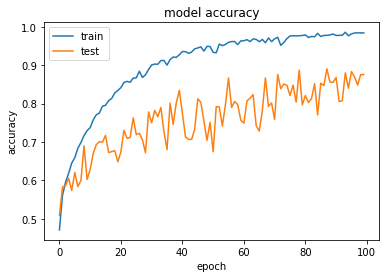

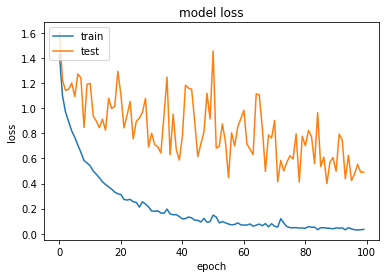

In [16]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [17]:
y_pred = model.predict(X_test)

total = 0
accurate = 0
accurateindex = []
wrongindex = []

for i in range(len(y_pred)):
    if np.argmax(y_pred[i]) == np.argmax(y_test[i]):
        accurate += 1
        accurateindex.append(i)
    else:
        wrongindex.append(i)
        
    total += 1
    
print('Total-test-data;', total, '\taccurately-predicted-data:', accurate, '\t wrongly-predicted-data: ', total - accurate)

print('Accuracy:', round(accurate/total*100, 3), '%')

Total-test-data; 8767 	accurately-predicted-data: 7674 	 wrongly-predicted-data:  1093
Accuracy: 87.533 %


In [18]:
best_model = load_model('model.h5')

# compute predictions
y_pred_prob = np.around(best_model.predict(X_test),3)
y_pred = np.argmax(y_pred_prob,axis=1)

y_test2 = np.argmax(y_test,axis=1)

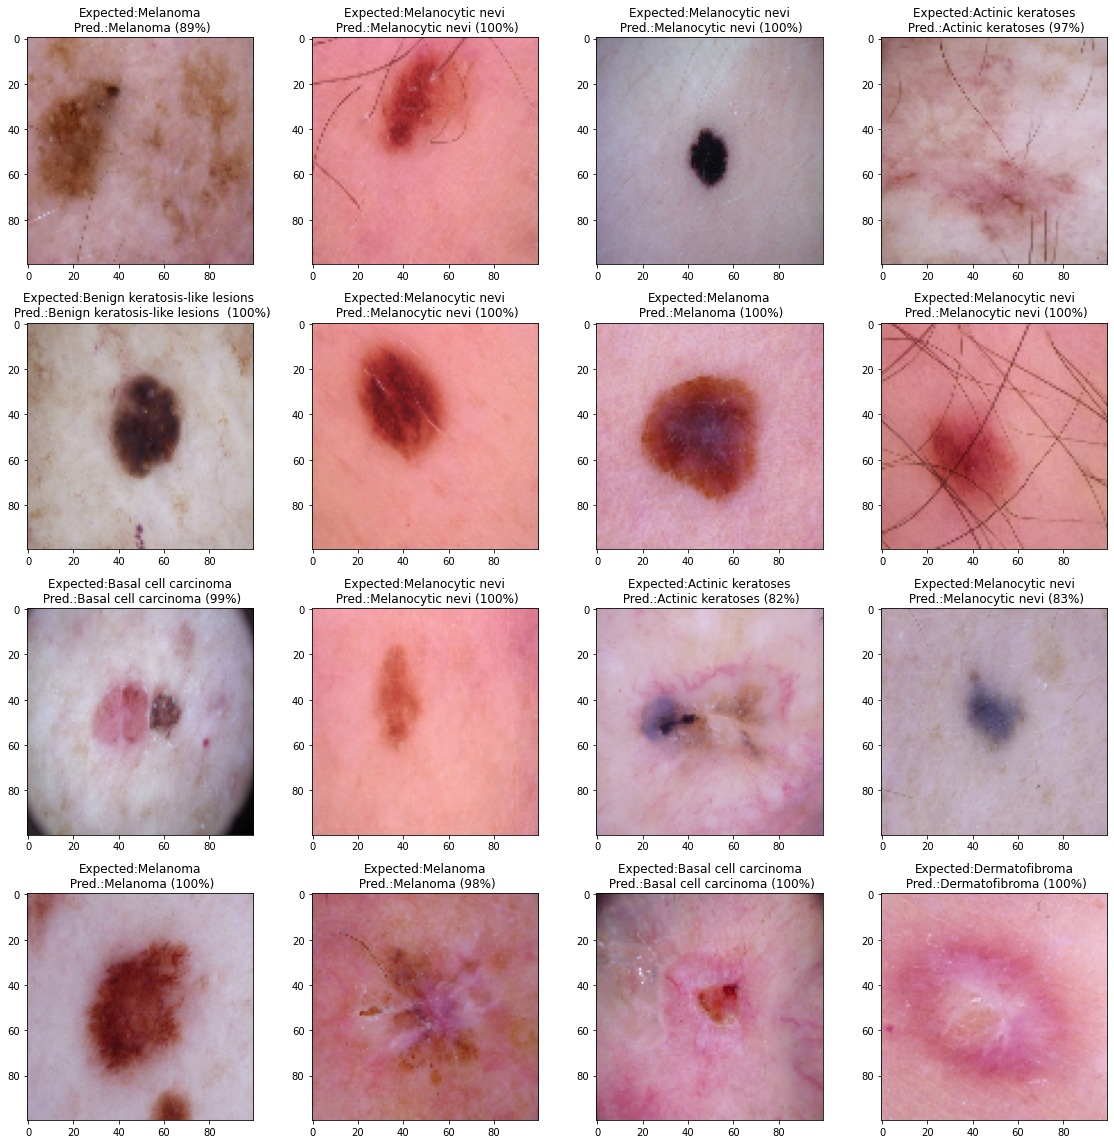

In [19]:
plt.figure(figsize=(16,16))
for i in range(16):
    plt.subplot(4,4,i+1)
    index = i+100
    plt.imshow(X_test[index,:,:,::-1])
    label_exp = lesion_names[y_test2[index]]  #expected label
    label_pred = lesion_names[y_pred[index]]  #predicted label
    label_pred_prob = round(np.max(y_pred_prob[index])*100)
    plt.title('Expected:'+str(label_exp)+'\n Pred.:'+str(label_pred)+' ('+str(label_pred_prob)+'%)')
plt.ylabel('')
plt.tight_layout()
plt.savefig('final_figure.png',dpi=300)
plt.show()

In [20]:
print('Accuracy for label equal to 0')
print(np.mean(y_test2[y_test2 == 0] == y_pred[y_test2 == 0]))

print('Accuracy for label different from 0')
print(np.mean(y_test2[y_test2 != 0] == y_pred[y_test2 != 0]))

Accuracy for label equal to 0
0.8820605512878446
Accuracy for label different from 0
0.8931949954226427


In [21]:
acc_tot= []

for i in range(7):
    acc_parz = round(np.mean(y_test2[y_test2 == i] == y_pred[y_test2 == i]),2)
    lab_parz = lesion_names[i]
    print('accuracy for',lab_parz,'=',acc_parz)
    acc_tot.append(acc_parz)

accuracy for Melanocytic nevi = 0.88
accuracy for Melanoma = 0.9
accuracy for Benign keratosis-like lesions  = 0.92
accuracy for Basal cell carcinoma = 0.84
accuracy for Actinic keratoses = 0.79
accuracy for Vascular lesions = 0.98
accuracy for Dermatofibroma = 0.98


In [22]:
acc_tot = np.array(acc_tot)
freq = np.unique(y_test2,return_counts=True)[1]

np.sum(acc_tot*freq)/np.sum(freq)

0.8894753051214782